# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [7]:
using Distributions
using LinearAlgebra
using Plots
using BenchmarkTools

All the necessary imports for our computations of interest

In [8]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

LoadError: LoadError: invalid redefinition of constant Main.ForwardTrajectory
in expression starting at /Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/trajectory.jl:124
in expression starting at /Users/jamosa/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/rollout.jl:18

## Basic Setup

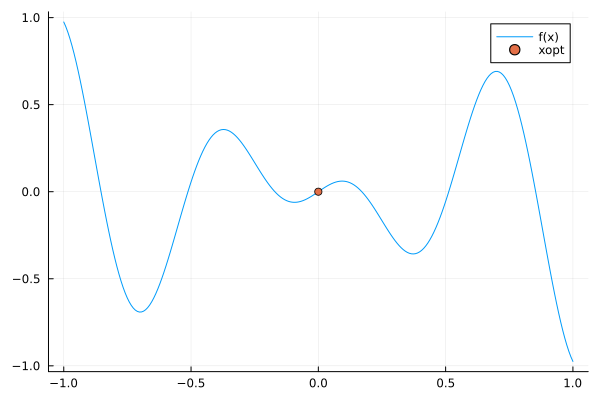

In [3]:
# Visualize 1D test function
testfn = scale(TestLinearCosine1D(1., 9.2), 1.)
# testfn = TestQuadratic1D()
# testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

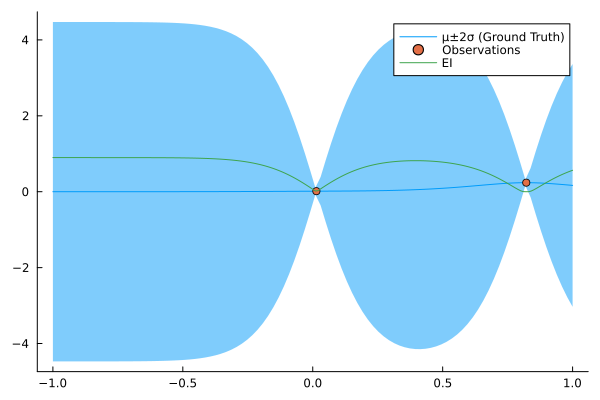

In [4]:
MC_SAMPLES = 100
NUMBER_OF_STARTS = 32
HORIZON = 0
USE_LDS = true
INITIAL_SAMPLES = 2

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = get_bounds(testfn)
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize the trajectory parameters
tp = initialize_trajectory_parameters(
    start=initial_guesses[:, 1],
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    lowerbounds=lbs,
    upperbounds=ubs
)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn(Xinit)

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))
EIb = [sur([x]).EI for x in domain]
plot!(domain, EIb, label="EI")

## On Perturbing the jth Policy Solve

Given some policy solve $r_j$, we have the following dependence structure on previous observations:

$$
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfr}{\mathbf{r}}
\bfr_j(\bfx_j; \bfx_0, y_0, \ldots, \bfx_{j-1}, y_{j-1}) = 0
$$

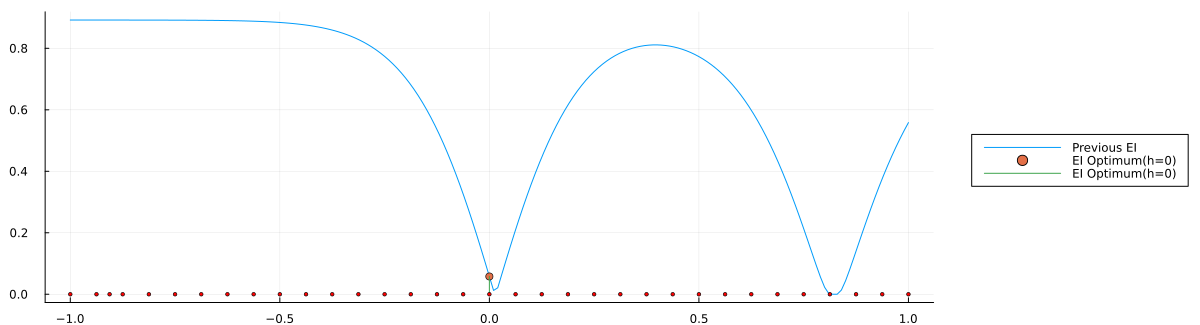

In [5]:
# Create the trajectory
# AT = AdjointTrajectory(sur, tp.x0, tp.h)
AT = AdjointTrajectory(base_surrogate=sur, start=tp.x0, horizon=tp.h)
stochastic_sampler = StochasticObservable(surrogate=AT.fs, stdnormal=get_samples_rnstream(tp, sample_index=1), max_invocations=HORIZON + 1)
deterministic_sampler = DeterministicObservable(testfn, max_invocations=HORIZON + 1)
attach_observable!(AT, deterministic_sampler)

# Adjoint Rollout
adjoint_rollout!(AT, lowerbounds=tp.lbs, upperbounds=tp.ubs, xstarts=initial_guesses, get_observation=get_observable(AT))

all_plots = []
for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = AT.fs([xx], fantasy_index=upto_index-1).EI
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    scatter!([target_location], [AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    plot!([target_location, target_location], [0., AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    scatter!(p, initial_guesses, zeros(NUMBER_OF_STARTS), color=:red, label=nothing, markersize=2)
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [6]:
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)

dense_acquisition = zeros(length(domain))
dense_forward_acquisition = zeros(length(domain))
dense_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_forward_gradient_acquisition = zeros(testfn.dim, length(domain))
fd_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_std = zeros(length(domain))
h = 1e-6

for (index, xx) in enumerate(domain)
    print("|")
    tp.x0 = [xx]
    # Adjoint mode
    # dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = simulate_adjoint_trajectory(
    #     sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    # )
    dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = deterministic_simulate_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    )

    # Finite difference mode
    tp.x0 = [xx - h]
    # aminus, _, _ = simulate_adjoint_trajectory(
    #     sur, tp_fm, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    # )
    aminus, _, _ = deterministic_simulate_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    )

    tp.x0 = [xx + h]
    # aplus, _, _ = simulate_adjoint_trajectory(
    #     sur, tp_fm, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    # )
    aplus, _, _ = deterministic_simulate_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    )
    fd_gradient_acquisition[:, index] .= (aplus - aminus) / 2h

    # Forward mode
    # tp_fm.x0 = [xx]
    # dense_forward_acquisition[index], _, dense_forward_gradient_acquisition[:, index] = simulate_trajectory(
    #     sur, tp_fm, initial_guesses, αxs=resolutions, ∇αxs=gresolutions
    # )
end

|

LoadError: MethodError: no method matching resolve(::AdjointTrajectory)

[0mClosest candidates are:
[0m  resolve([91m::Trajectory[39m)
[0m[90m   @[39m [35mMain[39m [90m~/Documents/academia/cornell-university/research/projects/kernel-numerics-refactor-revamp/[39m[90m[4mrollout.jl:257[24m[39m


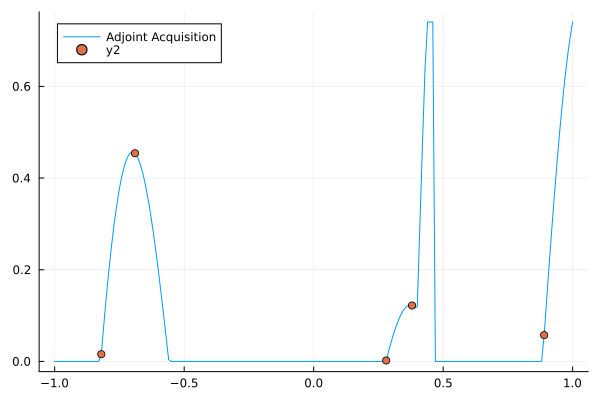

In [13]:
# plot(domain, stdize(dense_acquisition), ribbons=dense_std ./ sqrt(MC_SAMPLES), label="α(h=$HORIZON)")
slice = 1:length(domain)
plot(domain[slice], dense_acquisition[slice], label="Adjoint Acquisition")
zeros_indices = find_zeros(dense_gradient_acquisition[1, slice])
scatter!(domain[zeros_indices], dense_acquisition[zeros_indices])
# plot!(domain[slice], dense_forward_acquisition[slice], label="MOGP Acquisition")

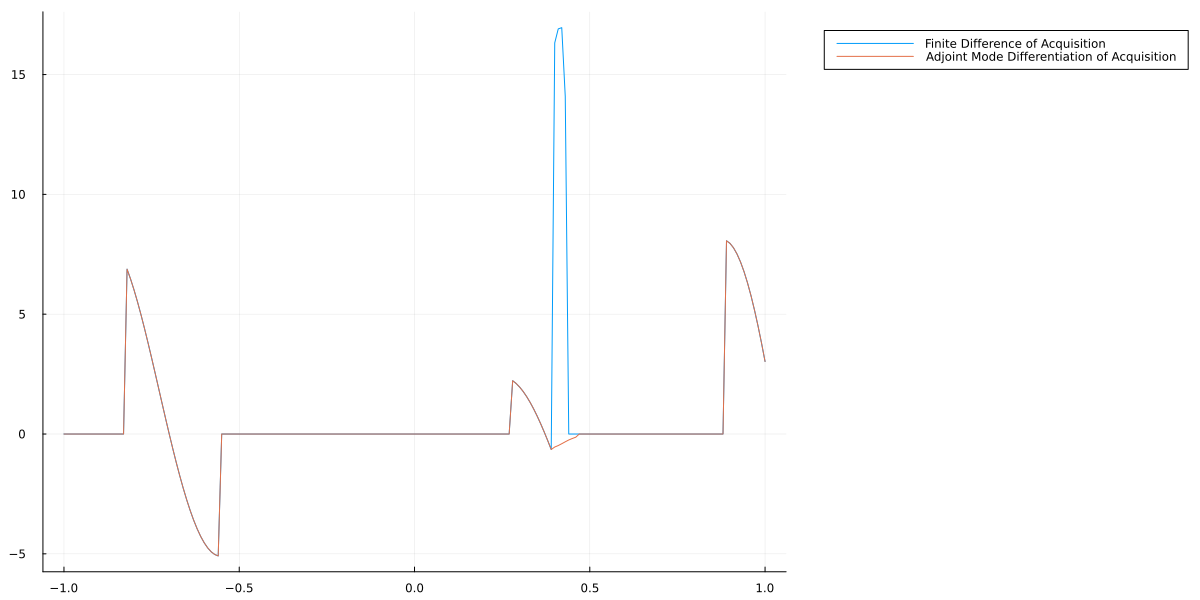

In [19]:
plot(domain[slice], fd_gradient_acquisition[1, slice], label="Finite Difference of Acquisition")
plot!(domain[slice], dense_gradient_acquisition[1, slice], label="Adjoint Mode Differentiation of Acquisition", legend=:outertopright, size=(1200, 600))
# plot!(domain[slice], dense_forward_gradient_acquisition[1, slice], label="forward dα(h=$HORIZON)")

## Sampling from Gaussian Process Posteriors

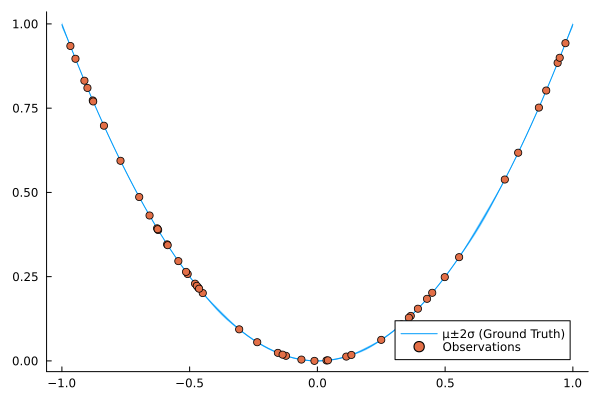

In [12]:
MC_SAMPLES = 10
NUMBER_OF_STARTS = 16
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 50

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
domain = first(lbs):.01:first(ubs)
Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
yinit = testfn.f.(eachcol(Xinit))

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

Depending on whether or not we want gradient draws from our Gaussian Process affects how we compute the cross-covariances and variance of the current location.

In [13]:
observation = zeros(testfn.dim + 1, length(domain)) 
stdnormal = randn(testfn.dim + 1)

for (index, xi) in enumerate(domain)
    observation[:, index] = gp_draw(sur, [xi], stdnormal=stdnormal, with_gradient=true)
end

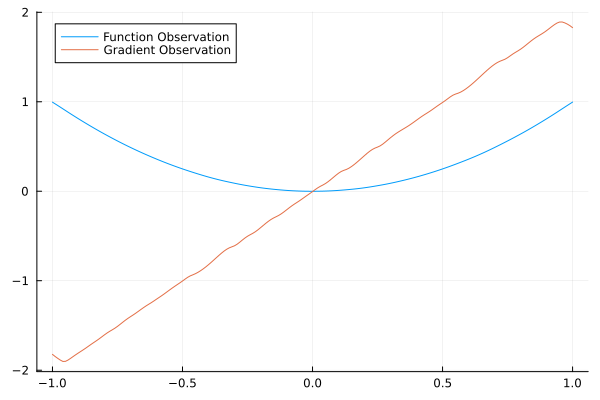

In [14]:
plot(domain, observation[1, :], label="Function Observation")
plot!(domain, observation[2, :], label="Gradient Observation")

In [63]:
T = AdjointTrajectory(sur, tp.x0, tp.h)
sampler = StochasticObservable(T.fs, tp_fm.rnstream_sequence[1, :, :], tp.h + 1)
attach_observable!(T, sampler)
adjoint_rollout!(T, tp.lbs, tp.ubs;
    get_observation=T.observable,
    xstarts=initial_guesses,
)

In [65]:
T.observable.observations

1-element Vector{Float64}:
 0.10023282816130596

In [31]:
gradient(t::TestFunction) = testfn.∇f

gradient (generic function with 2 methods)

In [32]:
gradient(testfn)([2.])

1-element Vector{Float64}:
 4.0

In [34]:
testfn([2.])

4.0